# Display Main Agent Graph

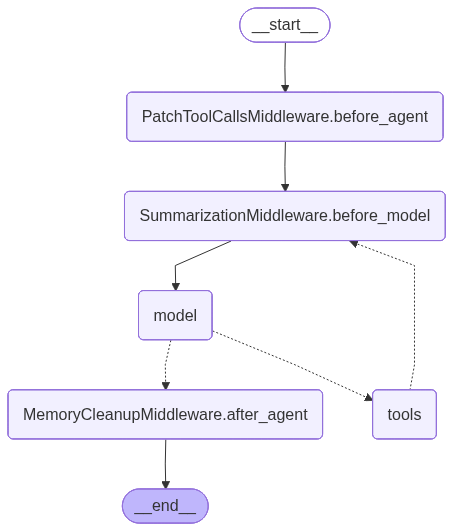

In [1]:
"""
Middleware Overview:
- PatchToolCallsMiddleware: This is default in-built middleware. Normalizes tool calls into the shape Deep Agents expects for 
  routing and message formatting. Built-in default to handle cases where the deep agent 
  is downstream of other agents.
  
- SummarizationMiddleware: This is default in-built middleware. Compacts conversation context before sending to the model when 
  token thresholds are exceeded, maintaining efficiency in long conversations.
  
- MemoryCleanupMiddleware: Prunes long-term memory to stay within token limits. This is 
  custom middleware we defined manually for this agent.

Note: Using xray=1 to show sub-agent internal graphs. Without xray, sub-agents appear 
as tools and their internal structure is hidden.
"""

import sys
sys.path.insert(0, '..')  # Add parent directory to path

from IPython.display import Image, display
from agents.main_agent import agent

# xray=1 shows the internal structure of sub-agents
display(Image(agent.get_graph(xray=1).draw_mermaid_png()))

# Deep Research Agent - Memory Management

This notebook allows you to:
1. View what's in the agent's long-term memory
2. Add memories manually (e.g., pre-seed website quality ratings)
3. Update or delete memories
4. Search memories semantically

## Setup

In [2]:
import os
import uuid
import json
from datetime import datetime
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Check if we have database connection
DATABASE_URL = os.environ.get("DATABASE_URL")
if DATABASE_URL:
    print(f"✅ PostgreSQL database configured")
else:
    print("❌  No DATABASE_URL found")

✅ PostgreSQL database configured


In [3]:
# Initialize the LangGraph store
from langgraph.store.postgres import PostgresStore

_store_cm = PostgresStore.from_conn_string(DATABASE_URL)
store = _store_cm.__enter__()

# Create the required tables
store.setup()

print("✅ Using PostgreSQL store")

✅ Using PostgreSQL store


## Memory Namespace Structure

The agent uses the `("filesystem",)` namespace with `/memories/` prefix for persistent storage.

Within this namespace, files are stored as:
- `/memories/website_quality.txt` - Website reliability ratings
- `/memories/research_lessons.txt` - What approaches worked well
- `/memories/source_notes.txt` - Notes about specific sources

In [4]:
# Define the namespace for agent memories
# Must be a TUPLE with a comma, not a string!
MEMORY_NAMESPACE = ("filesystem",)

## 1. View All Memories

In [5]:
def list_all_memories():
    """List all memories in the agent's namespace."""
    # Get all items and filter for /memories/ prefix
    all_items = list(store.search(MEMORY_NAMESPACE))
    memories = [item for item in all_items if item.key.startswith("/memories/")]
    
    if not memories:
        print("📭 No memories found")
        return []
    
    print(f"📚 Found {len(memories)} memories:\n")
    for i, mem in enumerate(memories, 1):
        print(f"--- Memory {i} ---")
        print(f"Key: {mem.key}")
        print(f"Created: {mem.created_at}")
        print(f"Updated: {mem.updated_at}")
        
        # Handle StoreBackend format (content is list of lines)
        if isinstance(mem.value.get("content"), list):
            content = "\n".join(mem.value["content"])
        else:
            content = json.dumps(mem.value, indent=2)
        
        if len(content) > 500:
            print(f"Content: {content[:500]}...")
        else:
            print(f"Content: {content}")
        print()
    
    return memories

# List all memories
all_memories = list_all_memories()

📭 No memories found


## 2. View Specific Memory File

In [6]:
def get_memory(key: str):
    """Get a specific memory by key."""
    try:
        # Key must include full path
        full_path = f"/memories/{key}" if not key.startswith("/memories/") else key
        
        memory = store.get(MEMORY_NAMESPACE, full_path)
        if memory:
            print(f"📄 Memory: {full_path}")
            print(f"Created: {memory.created_at}")
            print(f"Updated: {memory.updated_at}")
            
            # Handle StoreBackend format
            if isinstance(memory.value.get("content"), list):
                content = "\n".join(memory.value["content"])
            else:
                content = json.dumps(memory.value, indent=2)
            
            print(f"\nContent:\n{content}")
            return memory
        else:
            print(f"❌ Memory '{full_path}' not found")
            return None
    except Exception as e:
        print(f"❌ Error: {e}")
        return None

# Example: Get website quality memory
get_memory("website_quality.txt")

❌ Memory '/memories/website_quality.txt' not found


## 3. Overwrite Memories Manually

Use this to pre-seed Agent with Realistic Memories

These are memories the agent would naturally accumulate over time from doing research tasks.

In [7]:
def save_memory(key: str, content: str):
    """Save or update a memory in format compatible with StoreBackend."""
    # Key must include full path
    full_path = f"/memories/{key}" if not key.startswith("/memories/") else key
    
    timestamp = datetime.now().isoformat()
    store.put(
        MEMORY_NAMESPACE,
        full_path,
        {
            "content": content.split("\n"),  # Must be a list of lines
            "created_at": timestamp,
            "modified_at": timestamp,
        }
    )
    print(f"✅ Saved memory: {full_path}")

In [8]:
# Artificially seed memories the agent would naturally accumulate over time

# Memory 1: Website quality discoveries from "past research"
save_memory("website_quality.txt", """# Website Quality Ratings
Last updated: 2024-12-19

## Discovered High Quality Sources
- arxiv.org (5/5) - Academic preprints, excellent for ML/AI research
- nature.com (5/5) - Peer-reviewed, but often paywalled
- github.com (4/5) - Great for code examples, check stars/activity
- huggingface.co (4/5) - Reliable for ML models and documentation
- docs.python.org (5/5) - Authoritative Python documentation

## Sources That Disappointed
- medium.com (2/5) - Quality varies wildly, many clickbait articles
- dev.to (3/5) - Community content, verify claims independently
- w3schools.com (3/5) - Sometimes outdated, prefer MDN for web

## Domain-Specific Findings
- For AI/ML: prefer arxiv, paperswithcode.com, huggingface
- For APIs: always check official docs first
- For statistics: look for .gov or .edu sources
- For recent news: reuters.com and apnews.com most reliable
""")

# Memory 2: Research strategies that worked
save_memory("research_lessons.txt", """# Research Lessons Learned
Last updated: 2024-12-19

## Effective Search Patterns
- Adding "site:github.com" finds real implementations
- Adding "vs" helps compare technologies (e.g., "Redis vs Memcached")
- Adding year (2024) filters out outdated content
- "tutorial" finds beginner content, "deep dive" finds advanced

## What Didn't Work
- Generic searches return SEO-optimized fluff
- First result is often not the best result
- Stack Overflow answers over 3 years old may be outdated

## Verification Strategies
- Cross-reference claims across 3+ sources
- Check GitHub issues for real-world problems
- Look for benchmarks with methodology described
- Official documentation beats blog posts
""")

# Memory 3: Specific source notes
save_memory("source_notes.txt", """# Source Notes

## paperswithcode.com
- Excellent for finding implementations of ML papers
- Links papers to GitHub repos with code
- Has benchmark leaderboards

## stackoverflow.com
- Check answer dates - old answers may use deprecated APIs
- Accepted answer isn't always best - check votes
- Read comments for corrections

## twitter.com/x.com
- Not reliable for facts, but good for industry sentiment
- Researchers often announce papers here first
- Verify everything independently
""")

print("\n📚 All seed memories created!")
list_all_memories()

✅ Saved memory: /memories/website_quality.txt
✅ Saved memory: /memories/research_lessons.txt
✅ Saved memory: /memories/source_notes.txt

📚 All seed memories created!
📚 Found 3 memories:

--- Memory 1 ---
Key: /memories/source_notes.txt
Created: 2025-12-23 10:10:08.253217+00:00
Updated: 2025-12-23 10:10:08.253217+00:00
Content: # Source Notes

## paperswithcode.com
- Excellent for finding implementations of ML papers
- Links papers to GitHub repos with code
- Has benchmark leaderboards

## stackoverflow.com
- Check answer dates - old answers may use deprecated APIs
- Accepted answer isn't always best - check votes
- Read comments for corrections

## twitter.com/x.com
- Not reliable for facts, but good for industry sentiment
- Researchers often announce papers here first
- Verify everything independently


--- Memory 2 ---
Key: /memories/research_lessons.txt
Created: 2025-12-23 10:10:08.250760+00:00
Updated: 2025-12-23 10:10:08.250760+00:00
Content: # Research Lessons Learned
Last update

[Item(namespace=['filesystem'], key='/memories/source_notes.txt', value={'content': ['# Source Notes', '', '## paperswithcode.com', '- Excellent for finding implementations of ML papers', '- Links papers to GitHub repos with code', '- Has benchmark leaderboards', '', '## stackoverflow.com', '- Check answer dates - old answers may use deprecated APIs', "- Accepted answer isn't always best - check votes", '- Read comments for corrections', '', '## twitter.com/x.com', '- Not reliable for facts, but good for industry sentiment', '- Researchers often announce papers here first', '- Verify everything independently', ''], 'created_at': '2025-12-23T10:10:08.279546', 'modified_at': '2025-12-23T10:10:08.279546'}, created_at='2025-12-23T10:10:08.253217+00:00', updated_at='2025-12-23T10:10:08.253217+00:00', score=None),
 Item(namespace=['filesystem'], key='/memories/research_lessons.txt', value={'content': ['# Research Lessons Learned', 'Last updated: 2024-12-19', '', '## Effective Search Patterns

## 4. Append to Existing Memory

Example of adding new learnings to an existing memory file without overwriting the full memory.

In [10]:
def append_to_memory(key: str, new_content: str):
    """Append content to an existing memory."""
    full_path = f"/memories/{key}" if not key.startswith("/memories/") else key
    
    existing = store.get(MEMORY_NAMESPACE, full_path)
    if existing and "content" in existing.value:
        current_lines = existing.value["content"]
        new_lines = new_content.split("\n")
        updated_lines = current_lines + [""] + new_lines
        updated_content = "\n".join(updated_lines)
    else:
        updated_content = new_content
    
    save_memory(key, updated_content)

In [11]:
# Append a new discovery to existing research lessons
append_to_memory("research_lessons.txt", """
## New Discovery (added manually)
- For LangGraph questions: check github.com/langchain-ai/langgraph/discussions
- Community answers often more current than docs
""")

print("✅ Appended to research_lessons.txt")

✅ Saved memory: /memories/research_lessons.txt
✅ Appended to research_lessons.txt


In [12]:
get_memory("research_lessons.txt")

📄 Memory: /memories/research_lessons.txt
Created: 2025-12-19 11:41:28.277607+00:00
Updated: 2025-12-19 11:42:48.989553+00:00

Content:
# Research Lessons Learned
Last updated: 2024-12-19

## Effective Search Patterns
- Adding "site:github.com" finds real implementations
- Adding "vs" helps compare technologies (e.g., "Redis vs Memcached")
- Adding year (2024) filters out outdated content
- "tutorial" finds beginner content, "deep dive" finds advanced

## What Didn't Work
- Generic searches return SEO-optimized fluff
- First result is often not the best result
- Stack Overflow answers over 3 years old may be outdated

## Verification Strategies
- Cross-reference claims across 3+ sources
- Check GitHub issues for real-world problems
- Look for benchmarks with methodology described
- Official documentation beats blog posts



## New Discovery (added manually)
- For LangGraph questions: check github.com/langchain-ai/langgraph/discussions
- Community answers often more current than docs



Item(namespace=['filesystem'], key='/memories/research_lessons.txt', value={'content': ['# Research Lessons Learned', 'Last updated: 2024-12-19', '', '## Effective Search Patterns', '- Adding "site:github.com" finds real implementations', '- Adding "vs" helps compare technologies (e.g., "Redis vs Memcached")', '- Adding year (2024) filters out outdated content', '- "tutorial" finds beginner content, "deep dive" finds advanced', '', "## What Didn't Work", '- Generic searches return SEO-optimized fluff', '- First result is often not the best result', '- Stack Overflow answers over 3 years old may be outdated', '', '## Verification Strategies', '- Cross-reference claims across 3+ sources', '- Check GitHub issues for real-world problems', '- Look for benchmarks with methodology described', '- Official documentation beats blog posts', '', '', '', '## New Discovery (added manually)', '- For LangGraph questions: check github.com/langchain-ai/langgraph/discussions', '- Community answers often 

## 5. Delete All Memories

In [6]:
def clear_all_memories():
    """Delete ALL memories (use with caution!)."""
    # Get all items and filter for /memories/ prefix
    all_items = list(store.search(MEMORY_NAMESPACE))
    memory_items = [item for item in all_items if item.key.startswith("/memories/")]
    
    for mem in memory_items:
        store.delete(MEMORY_NAMESPACE, mem.key)
    
    print(f"🗑️ Cleared {len(memory_items)} memories")

# Example:
clear_all_memories()  # ⚠️ Careful!

🗑️ Cleared 4 memories
